In [1]:
from models.tennis_lstm import TennisLSTM
from dataloaders.vanilla_slam_loaders import YearOpenSplitLoader, YearOpenSplitDataSet

In [2]:
import numpy as np
import csv
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import random
import math
import json 
import torch
from torch.utils.data import DataLoader
torch.manual_seed(1)
batch_size = 1
from collections import defaultdict

In [3]:
test_slam_years=['2014-ausopen','2014-frenchopen', '2014-usopen', '2014-wimbledon']
test_data_set = YearOpenSplitDataSet(test_slam_years, get_match_info=True)
test_data_loader = DataLoader(test_data_set, batch_size=1, shuffle=True, num_workers=4)

['2014-ausopen', '2014-frenchopen', '2014-usopen', '2014-wimbledon']
dropped 0 matches
dropped 19 matches
dropped 2 matches
dropped 0 matches


In [4]:
from dataloaders.valid_data_fields import valid_fields
model_info = {'input_dim':len(valid_fields), 'hidden_dim':50, 'batch_size': 1, 
              'predict_mask':True, 'num_layers':2}


In [355]:
save_path = 'saved_models/tennis_lstm-lstm-1575668500.4425266.pt'
# save_path = 'saved_models/tennis_lstm-1575747148.265727.pt'
model = TennisLSTM(**model_info)
model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
model.eval()

TennisLSTM(
  (lstm): LSTM(51, 50, num_layers=2, dropout=0.1)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

winner should be 0.0 ('Andreas Seppi vs Lleyton Hewitt winner was 1, 2014-ausopen-1105',)


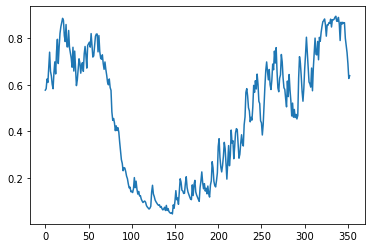

winner should be 1.0 ('Fernando Verdasco vs Teymuraz Gabashvili winner was 2, 2014-ausopen-1215',)


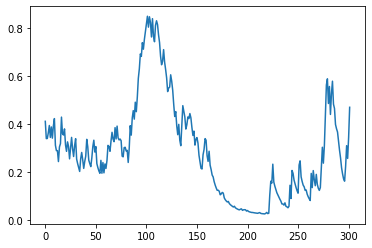

winner should be 1.0 ('Richard Gasquet vs Nick Kyrgios winner was 2, 2014-wimbledon-1229',)


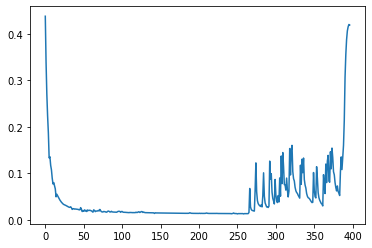

winner should be 0.0 ('Benoit Paire vs Julien Benneteau winner was 1, 2014-usopen-1112',)


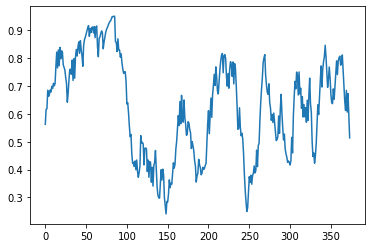

winner should be 0.0 ('Stanislas Wawrinka vs Novak Djokovic winner was 1, 2014-ausopen-1504',)


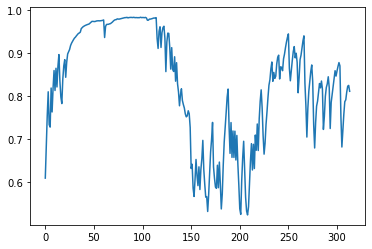

winner should be 0.0 ('Jiri Vesely vs Gael Monfils winner was 1, 2014-wimbledon-1230',)


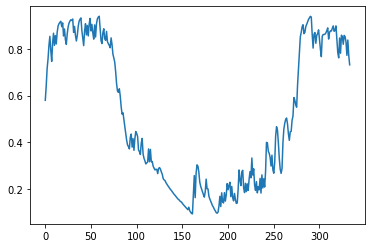

at 0.25 way through the match, predicted 585 out of 799 correctly 0.7321652065081352
at 0.5 way through the match, predicted 678 out of 799 correctly 0.8485607008760951
at 0.75 way through the match, predicted 713 out of 799 correctly 0.8923654568210263
at 1 way through the match, predicted 793 out of 799 correctly 0.9924906132665833


In [356]:
m = len(test_data_loader)
intervals=[0.25, 0.5, 0.75, 1]
correct = [0 for _ in intervals]
correct_points = 0
total_points = 0
post_set_correct = defaultdict(int)
set_length_games = defaultdict(int)

graph_intervals = [i/100 for i in range(1, 100)]
correct_intervals = [0 for _ in range(99)]

calibration_buckets = {}
calibration_buckets_true = {}
for i in intervals:
    calibration_buckets[i] = [0 for _ in range(11)]
    calibration_buckets_true[i] = [0 for _ in range(11)]


for i, test_example in enumerate(test_data_loader):
    x, prematch_probs, y, info = test_example
    prematch_probs = prematch_probs.float()
#     print(prematch_probs)
    model.hidden = model.set_prematch_probs(prematch_probs)
    # x, y, debug_string = test_example
    x = x.float()
    y = y.float().cpu().detach().numpy().squeeze()
    preds = model(x)[0].cpu().detach().numpy().squeeze()

    correct_points += np.sum(np.abs(preds - y) < 0.5)
    total_points += x.shape[1]
    
    set_winner_index = valid_fields.index('SetWinner')
    set_winning_points = (x[:,:,set_winner_index] != 0).squeeze()
    assert set_winning_points.shape == (abs(preds - y) < 0.5).shape
    set_winning_accuracy = (abs(preds - y) < 0.5)[set_winning_points]
    for i in range(set_winning_accuracy.shape[0]):
        post_set_correct[i] += int(set_winning_accuracy[i])
        set_length_games[i] += 1
    
    if abs(preds[-1] - y[-1]) > 0.5:
        print('winner should be', y[-1], info)
        fig = plt.figure()
        ax = plt.axes()

        ax.plot(preds);
        plt.show()
    
    points_correct_in_match = np.abs(preds - y) < 0.5
    
    for i, interval in enumerate(graph_intervals):
        correct_intervals[i] += points_correct_in_match[max(0, int(interval * (len(preds))), - 1)]
    
    for i, interval in enumerate(intervals):
        gt =  y[-1]
        pred = preds[int(interval * len(preds)) - 1]
        confidence =int(100 * pred)//10
        calibration_buckets[interval][confidence] += 1
        
        if abs(pred - gt) < 0.5:
            correct[i] += 1
            calibration_buckets_true[interval][confidence] += 1
for interval, correct in zip(intervals, correct):
    print(f'at {interval} way through the match, predicted {correct} out of {m} correctly {correct / m}')
    


In [354]:
print(correct_points/total_points)

0.7946851867254429


In [ ]:
for set_no in post_set_correct:
    print(f'after set {set_no + 1}, predicted {post_set_correct[set_no]/set_length_games[set_no]} correctly')

In [120]:
correct_intervals_percentage = [x/m for x in correct_intervals]

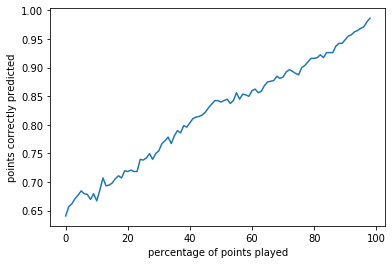

In [122]:
fig = plt.figure()
ax = plt.axes()
ax.set_ylabel('points correctly predicted')
ax.set_xlabel('percentage of points played')

ax.plot(correct_intervals_percentage);
plt.show()

0.25
[57, 36, 28, 35, 29, 25, 33, 18, 15, 19, 16, 24, 19, 17, 17, 29, 29, 31, 57, 51, 0]
0 0.95
1 0.9230769230769231
2 0.8235294117647058
3 0.813953488372093
4 0.6904761904761905
5 0.6410256410256411
6 0.75
7 0.5454545454545454
8 0.5555555555555556
9 0.6129032258064516
10 0.43243243243243246
11 0.5853658536585366
12 0.7037037037037037
13 0.7083333333333334
14 0.5862068965517241
15 0.7073170731707317
16 0.6590909090909091
17 0.7560975609756098
18 0.8636363636363636
19 0.8947368421052632

0.5
[107, 42, 37, 46, 24, 21, 15, 20, 18, 16, 16, 14, 18, 19, 17, 18, 34, 42, 48, 106, 0]
0 0.9553571428571429
1 0.9130434782608695
2 0.925
3 0.8846153846153846
4 0.7058823529411765
5 0.8076923076923077
6 0.7142857142857143
7 0.8333333333333334
8 0.72
9 0.7619047619047619
10 0.6666666666666666
11 0.5833333333333334
12 0.75
13 0.76
14 1.0
15 0.75
16 0.7906976744186046
17 0.7368421052631579
18 0.9411764705882353
19 0.9724770642201835

0.75
[163, 50, 40, 34, 23, 10, 16, 18, 10, 7, 7, 11, 13, 9, 10, 17, 30,

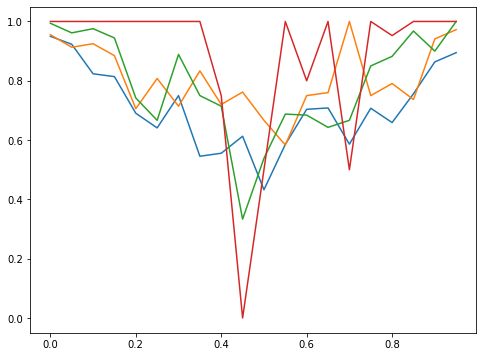

In [347]:
x = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50,
              55, 60, 65, 70, 75, 80, 85, 90, 95]) / 100
plt.figure(figsize = [8, 6])
labels = ['25% of match', '50% of match', '75% of match', 'perfect calibration']

for match_per in calibration_buckets:
    predicted, correct = calibration_buckets[match_per], calibration_buckets_true[match_per]
    print(match_per)
    print(correct)
    correct_rates = []
    for i, num_in_bucket in enumerate(predicted):
        if num_in_bucket > 0:
            print(i, correct[i]/num_in_bucket)
            if x[i] < 50:
                correct_rates.append(correct[i]/num_in_bucket)
            else:
                correct_rates.append(correct[i]/num_in_bucket)
    plt.plot(x, correct_rates)
    print()
plt.show()
    

In [16]:
from metrics.base_metrics import get_interval_success_rates

In [18]:
interval_metrics = get_interval_success_rates(model, test_data_loader, device='cpu')

testing on 799 examples
at 0.5 way through the match, predicted 670 out of 799 correctly
at 0.75 way through the match, predicted 715 out of 799 correctly
at 1 way through the match, predicted 787 out of 799 correctly
predicted 0.7947822229615459 of all points correctly


In [19]:
from dataloaders.valid_data_fields import valid_fields

In [22]:
def get_set_accuracy(y_pred, y_gt, x):
    set_winners = x[:]

x, probs, y = test_data_set[0]

In [26]:
set_winner_index = valid_fields.index('SetWinner')

array([ True, False, False, False,  True, False,  True,  True,  True,
        True,  True,  True,  True, False,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True])

In [28]:

def get_set_accuracy(y_pred, y_gt, x):
    set_winner_index = valid_fields.index('SetWinner')
    set_winning_points = x[set_winner_index,:] != 0
    set_winning_accuracy = (abs(preds - y) > 0.5)[set_winning_points]
    for i in range(set_winning_accuracy.shape[0]):
        print(set_winning_accuracy[i])


In [208]:
ds_iter = enumerate(test_data_loader)

tensor([1., 1., 1.])
tensor([[ 40, 117, 175]])
winner should be 0.0
('Rafael Nadal vs Leonardo Mayer winner was 1, 2014-frenchopen-1301',)


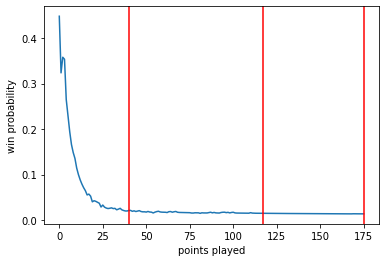

In [363]:
i, test_example = next(ds_iter)
x, prematch_probs, y, info = test_example
prematch_probs = prematch_probs.float()
#     print(prematch_probs)
model.hidden = model.set_prematch_probs(prematch_probs)
# x, y, debug_string = test_example
x = x.float()
y = y.float().cpu().detach().numpy().squeeze()
preds = model(x)[0].cpu().detach().numpy().squeeze()

set_winner_index = valid_fields.index('SetWinner')
set_winning_points = (x[:,:,set_winner_index] != 0).squeeze()
set_winners = x[:,:,set_winner_index].squeeze()[set_winning_points]
print(set_winners)

set_indexes = np.argwhere(set_winning_points)
print(set_indexes)

set_winning_accuracy = (abs(preds - y) < 0.5)[set_winning_points]

print('winner should be', y[-1])
print(info)
fig = plt.figure()
ax = plt.axes()
ax.set_ylabel('win probability')
ax.set_xlabel('points played')

ax.plot(preds);
for i, set_index in enumerate(set_indexes.numpy()[0]):
    set_winner = set_winners[i].numpy()
    if set_winner == 1:
        color = 'r'
    else:
        color = 'b'
    ax.axvline(x=set_index, c=color)
plt.show()


In [196]:
confidences = []
for i, test_example in enumerate(test_data_loader):
    x, prematch_probs, y, info = test_example
    prematch_probs = prematch_probs.float()
#     print(prematch_probs)
    model.hidden = model.set_prematch_probs(prematch_probs)
    # x, y, debug_string = test_example
    x = x.float()
#     y = y.float().cpu().detach().numpy().squeeze()
    confidence = model(x)[1].cpu().detach().numpy().squeeze()
    confidences.append(confidence)

KeyboardInterrupt: 

In [287]:
confidences

[array([0.5064516 , 0.5082936 , 0.49948895, 0.4959246 , 0.4891535 ,
        0.48847622, 0.49011612, 0.49469322, 0.499398  , 0.5143654 ,
        0.51743203, 0.48202035, 0.50203824, 0.48898113, 0.4912827 ,
        0.5071538 , 0.5203324 , 0.49766842, 0.48145643, 0.48398533,
        0.48582977, 0.4870362 , 0.497184  , 0.4978689 , 0.50598234,
        0.5265458 , 0.5114488 , 0.5230051 , 0.47962946, 0.51325876,
        0.52392745, 0.51223624, 0.52424   , 0.47958472, 0.47347304,
        0.5108549 , 0.5144954 , 0.5247131 , 0.5176152 , 0.530774  ,
        0.53460616, 0.5280402 , 0.5262149 , 0.52221644, 0.5224383 ,
        0.51856875, 0.51667   , 0.51035297, 0.5189732 , 0.5213851 ,
        0.5140836 , 0.5155128 , 0.50707436, 0.5066979 , 0.50961447,
        0.5124155 , 0.50941044, 0.5087967 , 0.5004721 , 0.5060836 ,
        0.51211   , 0.511807  , 0.50203264, 0.49959955, 0.51300365,
        0.51183724, 0.5140787 , 0.5103212 , 0.51057124, 0.5052256 ,
        0.4963005 , 0.50661325, 0.50949115, 0.51

In [318]:
train_slam_years=['2011-ausopen', '2011-frenchopen', '2011-usopen', '2011-wimbledon',
              '2012-ausopen', '2012-frenchopen', '2012-usopen', '2012-wimbledon',
              '2013-ausopen', '2013-frenchopen', '2013-usopen', '2013-wimbledon',
              '2015-ausopen', '2015-frenchopen', '2015-usopen', '2015-wimbledon',
              '2016-ausopen', '2016-frenchopen', '2016-usopen', '2016-wimbledon',
              ]

In [319]:
train_data_set = YearOpenSplitDataSet(train_slam_years)

['2011-ausopen', '2011-frenchopen', '2011-usopen', '2011-wimbledon', '2012-ausopen', '2012-frenchopen', '2012-usopen', '2012-wimbledon', '2013-ausopen', '2013-frenchopen', '2013-usopen', '2013-wimbledon', '2015-ausopen', '2015-frenchopen', '2015-usopen', '2015-wimbledon', '2016-ausopen', '2016-frenchopen', '2016-usopen', '2016-wimbledon']
dropped 1 matches
dropped 1 matches
dropped 0 matches
dropped 0 matches
dropped 0 matches
dropped 1 matches
dropped 1 matches
dropped 0 matches
dropped 0 matches
dropped 10 matches
dropped 0 matches
dropped 0 matches
dropped 1 matches
dropped 11 matches
dropped 0 matches
dropped 1 matches
dropped 0 matches
dropped 0 matches
dropped 0 matches
dropped 0 matches


In [320]:
train_data_loader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [322]:
from metrics.base_metrics import get_interval_success_rates


In [353]:
interval_metrics = get_interval_success_rates(model, test_data_loader, 'cpu')

testing on 799 examples


ValueError: too many values to unpack (expected 3)